# Basic Metropolis-Hastings MCMC 
use random walk  based proposals

points for illustration:
 * tightness of priors, effect on posterior and dependencies
 * size of random walk variance and mixing (0.001 works OK)
 * monitoring the acceptance probabiliy

In [1]:
import numpy as np
from scipy.integrate import odeint

In [2]:
theta = (0.25, 0.1) # γ, λ
T = 30
t = np.arange(T)
P0 = 1.0

In [3]:
def simulate(P, t, γ, λ):
    om = 2.0*np.pi/365.0
    return γ *(1+np.sin(om*t))*P - λ*P**2

In [4]:
def loglike(theta,obs):
    # step 1: run the model given the parameters to get state
    tobs = obs['t']
    yobs = obs['y']
    
    P = 2.5
    xhat = odeint(simulate, P, tobs, args=tuple(theta))[:,0]
    
    # step 2: compute the likelihood (compare state to observations)
    return -np.sum((yobs-xhat)**2)

### load in some (synthetic) observations

In [5]:
datafile = 'data/obs.csv'

data = np.loadtxt(datafile, skiprows=1, delimiter=',')

obs = {
    't':data[:,0],
    'y':data[:,1],
}

### The M-H algorithm

In [6]:
import scipy.stats as stats

# setup
nc = 1000 # number of iterations (length of the chain)
theta_acc = np.full((nc,2), fill_value=np.nan) # accumulator for posterior samples (parameters)

theta_old = (0.25, 0.1) # initial condition for chain (parameter values)

# priors (use uniforms so set upper and lower bounds)
gamma_bar = 0.25 # gamma mean
lambda_bar = 0.1 # lambda mean
gam_sd = 0.05
lam_sd = 0.02

# random walk std
rw_sd = 0.001

for ic in range(nc):
    # Step 1: Generate Trial Candidate  
    # use random walk based on previous value of the chain

    theta_c = theta_old + rw_sd*np.random.normal(size=2)
    
    # Step 2: Compute acceptance probability for this candidate
    # log likelihood for for candidate/trail particle
    like_num = loglike(theta_c, obs)
    p_gam = stats.norm.logpdf(theta_c[0],loc=gamma_bar, scale=gam_sd)
    p_lam = stats.norm.logpdf(theta_c[1],loc=lambda_bar,scale=lam_sd)
    prior_num = p_gam + p_lam 

    # log likelihood for current particle (last member of the chain/sample)
    like_denom = loglike(theta_old, obs)
    p_gam = stats.norm.logpdf(theta_old[0],loc=gamma_bar, scale=gam_sd)
    p_lam = stats.norm.logpdf(theta_old[1],loc=lambda_bar,scale=lam_sd)
    prior_denom = p_gam + p_lam
    
    # ratio of posteriors (candidate vs current)
    ratio = np.exp((like_num+prior_num) - (like_denom+prior_denom))

    A = min(1,ratio) # acceptance probability

    # Step 3: Choose whether to accept candidate
    # accept candidate with probability A, otherwise revert to previous chain member
    if np.random.uniform() <= A:
        theta_new = theta_c
    else:
        theta_new = theta_old

    # add result to the sample accumulator
    theta_acc[ic,:] = theta_new
    theta_old = theta_new # make new particle the current particle for iterations

### plot the results

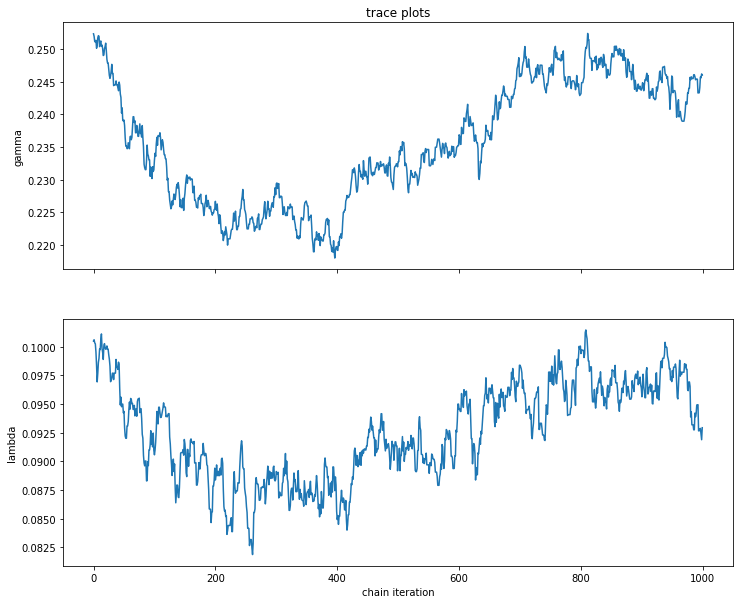

In [11]:
import matplotlib.pyplot as plt

# trace plots

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(12,10))
axs[0].plot(theta_acc[:,0])
axs[0].set(ylabel='gamma', title='trace plots')
axs[1].plot(theta_acc[:,1])
axs[1].set(ylabel='lambda', xlabel='chain iteration')
None

Text(0,0.5,'frequency')

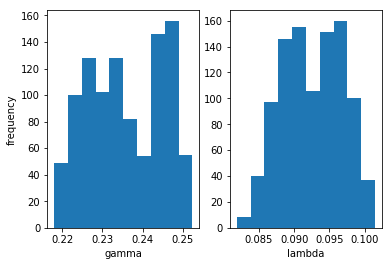

In [8]:
# histograms
fig, axs = plt.subplots(ncols=2)
for iax,name in enumerate(('gamma','lambda')):
    axs[iax].hist(theta_acc[:,iax])
    axs[iax].set_xlabel(name)
    
axs[0].set_ylabel('frequency')

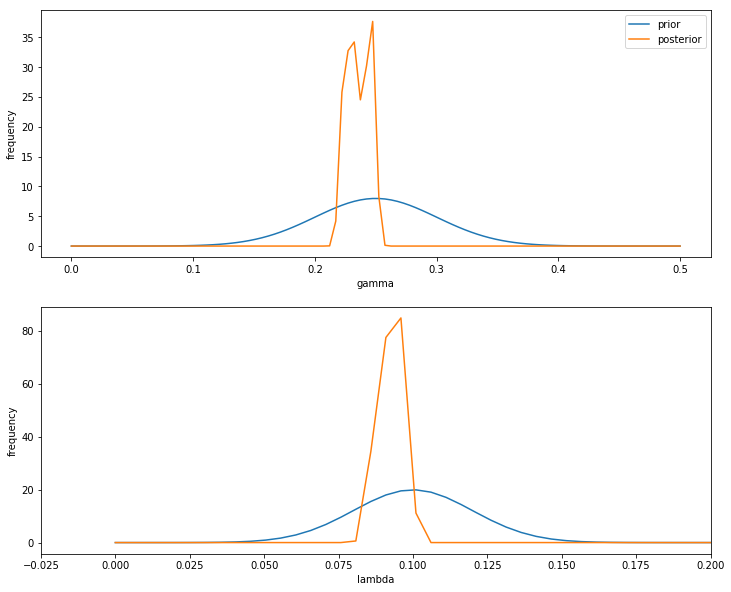

In [12]:
# prior and posterior
import scipy.stats

x = np.linspace(0.0, 0.5, 100)

fig, axs = plt.subplots(nrows=2, figsize=(12,10))
axs[0].plot(x,stats.norm.pdf(x,loc=gamma_bar,scale=gam_sd), label='prior')
axs[1].plot(x,stats.norm.pdf(x,loc=lambda_bar,scale=lam_sd), label='prior')
for iax,name in enumerate(('gamma','lambda')):
    # kernel smooth density
    ksd = scipy.stats.gaussian_kde(theta_acc[:,iax])
    axs[iax].plot(x,ksd(x),label='posterior')
    axs[iax].set(xlabel=name, ylabel='frequency')
axs[0].legend()
axs[1].set_xlim(right=0.2)
None

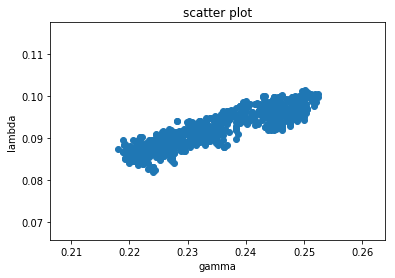

In [10]:
# scatter plot of joint distribution
fig, ax = plt.subplots()
ax.scatter(theta_acc[:,0], theta_acc[:,1])
ax.set(title='scatter plot', xlabel='gamma', ylabel='lambda')
None